<a href="https://colab.research.google.com/github/leticiari03/Tinder-Love-it-or-Hate-It/blob/main/FINAL_Tinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
drive_dir = '/content/drive/Shareddrives/Tinder - Project 4/'

Mounted at /content/drive


In [26]:
df=pd.read_csv(drive_dir + 'tinder_google_play_reviews.csv')

In [27]:
df['content'] = df['content'].fillna('').astype(str).str.replace(r'[^A-Za-z ]', '', regex=True).replace('', np.nan, regex=False)

In [28]:
df = df.drop(['reviewId','userName','userImage'],axis=1)

In [29]:
df['at']=pd.to_datetime(df['at'])

In [30]:
df['date'] = df['at'].dt.date
df['time'] = df['at'].dt.time
df['day'] = df['at'].dt.day

In [31]:
df["month"] = df['date'].map(lambda x: x.month)
df["year"] = df['date'].map(lambda x: x.year)

In [32]:
df=df.drop(['replyContent','repliedAt','reviewCreatedVersion'], axis=1)

In [33]:
df = df.dropna()

In [34]:
df = df[df.score != 0]

In [35]:
df['score'] = df['score'].astype(np.uint8)
df['thumbsUpCount'] = df['thumbsUpCount'].astype(np.uint8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Polarity Column**

In [36]:
df['Polarity_Rating'] = df['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
tinder_palette = ["#FD297B","#FF5864",'#FF655B']

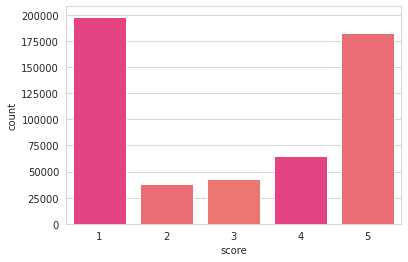

In [38]:
tinder_palette = ["#FD297B","#FF5864",'#FF655B']
sns.set_style('whitegrid')
sns.countplot(x='score',data=df, palette=tinder_palette)

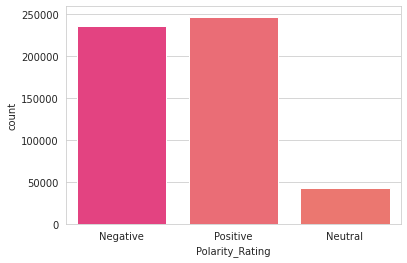

In [39]:
sns.set_style('whitegrid')
sns.countplot(x='Polarity_Rating',data=df, palette=tinder_palette)

In [40]:
df_Positive = df[df['Polarity_Rating'] == 'Positive']
df_Neutral = df[df['Polarity_Rating'] == 'Neutral']
df_Negative = df[df['Polarity_Rating'] == 'Negative']

Sample negative and neutral dataset and create a final dataset:

In [41]:
df_Neutral_over = df_Neutral.sample(n=8000, replace=True)
df_Negative_over = df_Negative.sample(n=8000, replace=True)
df = pd.concat([df_Positive, df_Neutral_over, df_Negative_over], axis=0)

**Text Preprocessing:**

In [42]:
def get_text_processing(text, remove_punctuation=True, remove_stopwords=True):
    stpword = stopwords.words('english')
    if remove_punctuation:
      try:
        text_chars = [char for char in text if char not in string.punctuation]
        text = ''.join(text_chars)
      except:
        print(text)
    if remove_stopwords:
      text = ' '.join([word for word in text.split() if word.lower() not in stpword])
    return text

In [43]:
df['review'] = df['content'].apply(get_text_processing)

In [44]:
from collections import Counter
most_occur = Counter(df['review']).most_common(20)
most_occur

[('Good', 12046),
 ('good', 6856),
 ('Nice', 5773),
 ('Great', 4924),
 ('Awesome', 4099),
 ('Love', 3363),
 ('Great app', 3107),
 ('Good app', 2634),
 ('Cool', 2594),
 ('Nice app', 2578),
 ('nice', 2548),
 ('great', 1822),
 ('love', 1526),
 ('Ok', 1423),
 ('good app', 1410),
 ('cool', 1394),
 ('', 1358),
 ('ok', 1254),
 ('Excellent', 1230),
 ('Fun', 1219)]

In [45]:
df['review'] = df['review'].apply(lambda x: x.lower())

Stemming Review Column

In [46]:
from nltk.stem.snowball import SnowballStemmer

In [47]:
ss=SnowballStemmer(language="english")

In [48]:
df['review'] = df['review'].str.split()
df['stemmed'] = df['review'].apply(lambda x: [ss.stem(y) for y in x]) # Stem every word.
df = df.drop(columns=['review'])

In [49]:
df['stemmed']= df['stemmed'].str.join(' ')

Vectorization

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer1 = TfidfVectorizer(max_features=1500)
X = vectorizer1.fit_transform(df['stemmed'])

In [52]:
X = vectorizer1.fit_transform(df['stemmed']).toarray()
y = df['score']

In [53]:
vectorizer1.get_feature_names_out()

array(['aap', 'abil', 'abl', ..., 'youv', 'yup', 'zero'], dtype=object)

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)

In [ ]:
cv = CountVectorizer(max_features = 1500)
X = pca.fit_transform(cv.fit_transform(df['stemmed']).toarray())
y = df['Polarity_Rating']

In [ ]:
np.cumsum(pca.explained_variance_ratio_)

**Data Analysis**

In [ ]:
df_positive = df[df['Polarity_Rating']=='Positive']
df_neutral = df[df['Polarity_Rating']=='Neutral']
df_negative = df[df['Polarity_Rating']=='Negative']

In [ ]:
STOPWORDS = set(stopwords.words('english'))
text = df_negative['content'].tolist() 

In [ ]:
from wordcloud import WordCloud
from PIL import ImageFilter
from PIL import Image

text=Counter(df_negative['content']).most_common(20)
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white",colormap='spring',stopwords=STOPWORDS).generate(str(text))

plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
text=Counter(df_positive['content']).most_common(30)
wordcloud = WordCloud(max_font_size=55, max_words=30, background_color="white",colormap='spring',stopwords=STOPWORDS).generate(str(text))

plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
text=Counter(df_neutral['content']).most_common(30)
wordcloud = WordCloud(max_font_size=55, max_words=30, background_color="white",colormap='spring',stopwords=STOPWORDS).generate(str(text))

plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='month',data=df_negative, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='month',data=df_positive, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='month',data=df_neutral, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='year',data=df_neutral, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='year',data=df_positive, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='year',data=df_neutral, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='day',data=df_negative, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='day',data=df_positive, palette=tinder_palette)

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='day',data=df_neutral, palette=tinder_palette)

**Modeling**

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)

In [ ]:
classifier.score(X_test,y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, y_train)

In [ ]:
rf_clf.score(X_test,y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np


parameters = {'max_depth':np.arange(1,10,3), 
              'min_samples_split':np.arange(2,10,3),
              'min_samples_leaf':np.arange(1,10,3),
              'n_estimators':np.arange(100,300,100)}

In [ ]:
grid = GridSearchCV(rf_clf,parameters)

In [ ]:
grid.fit(X_train,y_train)

In [ ]:
grid.best_estimator_.score(X_test,y_test)

In [ ]:
confusion_matrix(y_test, grid.best_estimator_.predict(X_test))

In [ ]:
grid.best_params_

In [ ]:
np.unique(grid.best_estimator_.predict(X_test))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [ ]:
predictions = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=rf_clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_clf.classes_)
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
train_df, test_df= train_test_split(df, train_size=0.7)
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train_df['stemmed'])
test_matrix = vectorizer.transform(test_df['stemmed'])
white_check_mark
eyes
raised_hands


train_df, test_df= train_test_split(df, train_size=0.7)
X_train = train_matrix
X_test = test_matrix
y_train = train_df['stemmed']
y_test = test_df['stemmed']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
train_df, test_df= train_test_split(df, train_size=0.7)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0 )

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(max_iter=1000)

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
lr.score(X_test,y_test)

In [ ]:
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
SVC(random_state=0)

In [ ]:
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.grid(False)
plt.show()

In [ ]:
confusion_matrix(y_test, lr.predict(X_test), labels=[1,2,3,4,5],normalize="true")

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact